<a href="https://colab.research.google.com/github/dataemperor/Shrimple/blob/chanmini/shrimp_demand_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import datetime
from sklearn.model_selection import GridSearchCV

# File paths for uploaded .txt files in Colab
file_paths = {
    "Q1": "/content/Q1.txt",
    "Q2": "/content/Q2.txt",
    "Q3": "/content/Q3.txt",
      "Q4": "/content/Q4.txt"}

In [5]:
# Function to load a text file
def load_txt(file_path, quarter):
    df = pd.read_csv(file_path, sep="\t", engine="python")  # Tab-separated data
    df = df.melt(var_name="year", value_name="demand")  # Convert wide format to long format
    df["year"] = df["year"].str.extract('(\d{4})').astype(int)  # Extract the first year
    df["quarter"] = quarter  # Add quarter column
    return df


In [6]:

# Load and merge all data
dataframes = [load_txt(file_paths[q], i) for i, q in enumerate(["Q1", "Q2", "Q3", "Q4"], start=1)]
data = pd.concat(dataframes, ignore_index=True)


In [7]:

# Convert to datetime format
data["date"] = pd.to_datetime(data["year"].astype(str) + "Q" + data["quarter"].astype(str))
data = data.sort_values(by="date").reset_index(drop=True)


<ipython-input-7-3e1f80ddb26c>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["date"] = pd.to_datetime(data["year"].astype(str) + "Q" + data["quarter"].astype(str))


In [8]:

# Handle missing values
data["demand"] = pd.to_numeric(data["demand"], errors='coerce')  # Convert demand to numeric
data.fillna(method='ffill', inplace=True)  # Forward fill missing values


<ipython-input-8-1e6139106f11>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Forward fill missing values


In [9]:

# Feature Engineering
data["lag_1"] = data["demand"].shift(1)  # Previous quarter demand
data["lag_2"] = data["demand"].shift(2)  # Two quarters ago
data["rolling_mean"] = data["demand"].rolling(window=4).mean()  # Average over 4 quarters


In [10]:

# Drop missing values (after shift operations)
data.dropna(inplace=True)


In [11]:
from sklearn.preprocessing import StandardScaler
# Assuming 'lag_1', 'lag_2', and 'rolling_mean' are your features
X = data[['lag_1', 'lag_2', 'rolling_mean']]
y = data['demand']

# Apply scaling to features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the scaled data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)


In [ ]:


# Define a larger hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],  # Number of trees
    'max_depth': [10, 20, 30, 50, None],    # Depth of the tree
    'min_samples_split': [2, 5, 10, 20],    # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4, 10],      # Minimum samples required at leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider for split
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Display best parameters
print(f"Best parameters found: {grid_search.best_params_}")

# Use the best model to train
model = grid_search.best_estimator_
model.fit(X_train, y_train)


Fitting 5 folds for each of 1920 candidates, totalling 9600 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:

from sklearn.model_selection import TimeSeriesSplit

# Initialize TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Train the model using cross-validation
scores = []
for train_index, test_index in tscv.split(X_train):
    X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    model.fit(X_train_cv, y_train_cv)
    y_pred_cv = model.predict(X_test_cv)
    mse_cv = mean_squared_error(y_test_cv, y_pred_cv)
    scores.append(mse_cv)

# Print average cross-validation score
print(f"Average MSE from Cross-Validation: {np.mean(scores)}")


Average MSE from Cross-Validation: 51967.74208404623


In [ ]:
from sklearn.feature_selection import SelectFromModel

# Select important features based on feature importance
sfm = SelectFromModel(model, threshold=0.05)  # 0.05 means keep features with importance greater than 5%
sfm.fit(X_train, y_train)

# Transform the data to select important features
X_train_selected = sfm.transform(X_train)
X_test_selected = sfm.transform(X_test)


In [ ]:

# Make Predictions
y_pred = model.predict(X_test)


In [ ]:

# Evaluate Model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 38930.67391758241


In [ ]:

# Future Predictions (Next 4 Quarters)
future_year = data["year"].max() + 1
future_quarters = [1, 2, 3, 4]
future_data = pd.DataFrame({"year": [future_year] * 4, "quarter": future_quarters})


In [ ]:

# Generate lag values from the last known data point
latest_values = data.iloc[-1]
future_data["lag_1"] = [latest_values["demand"]] + [np.nan] * 3
future_data["lag_2"] = [latest_values["lag_1"]] + [latest_values["demand"]] + [np.nan] * 2
future_data["rolling_mean"] = latest_values["rolling_mean"]


In [ ]:
# Predict Future Demand
future_data.fillna(method="ffill", inplace=True)  # Fill missing lag values
features = ['lag_1', 'lag_2', 'rolling_mean']  # Define the features used in the model
future_data["forecast"] = model.predict(future_data[features])

<ipython-input-26-0bbda2dc018f>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_data.fillna(method="ffill", inplace=True)  # Fill missing lag values
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [ ]:

# Display Forecast
print("\nFuture Demand Forecast:")
print(future_data[["year", "quarter", "forecast"]])



Future Demand Forecast:
   year  quarter     forecast
0  2023        1  1441.537392
1  2023        2  1441.537392
2  2023        3  1441.537392
3  2023        4  1441.537392


<ipython-input-28-fec9a2903f13>:4: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  plt.plot(pd.date_range(start=data["date"].max(), periods=5, freq='Q')[1:], future_data["forecast"], label="Forecast", linestyle="dashed", color="red")


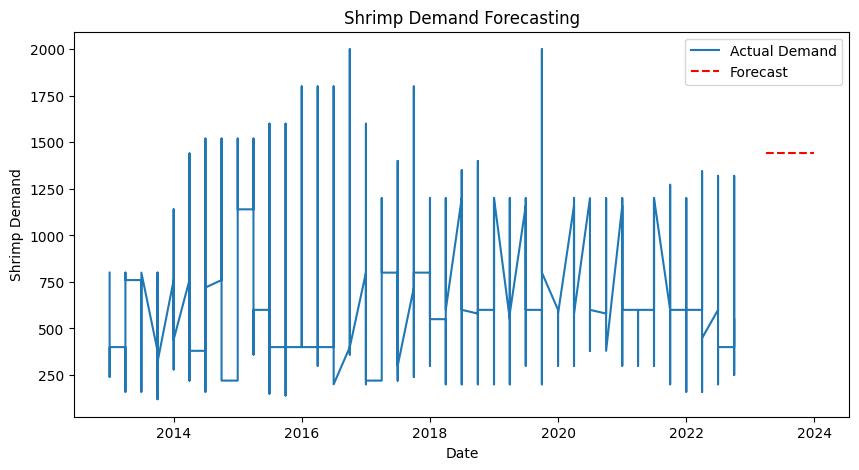

In [ ]:

# Plot Results
plt.figure(figsize=(10, 5))
plt.plot(data["date"], data["demand"], label="Actual Demand")
plt.plot(pd.date_range(start=data["date"].max(), periods=5, freq='Q')[1:], future_data["forecast"], label="Forecast", linestyle="dashed", color="red")
plt.xlabel("Date")
plt.ylabel("Shrimp Demand")
plt.title("Shrimp Demand Forecasting")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate Evaluation Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)

# Print Accuracy Results
print(f"📊 Model Performance Metrics:")
print(f"✅ Mean Absolute Error (MAE): {mae:.2f}")
print(f"✅ Mean Squared Error (MSE): {mse:.2f}")
print(f"✅ Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"✅ R² Score: {r2:.2f} (Closer to 1 means better model fit)")


📊 Model Performance Metrics:
✅ Mean Absolute Error (MAE): 143.92
✅ Mean Squared Error (MSE): 38930.67
✅ Root Mean Squared Error (RMSE): 197.31
✅ R² Score: 0.55 (Closer to 1 means better model fit)


In [3]:
import joblib

# Save the trained model
joblib.dump(model, "model.pkl")

# Save the scaler used for feature transformation
joblib.dump(scaler, "scaler.pkl")

print("✅ Model and Scaler saved successfully!")


NameError: name 'model' is not defined